In [89]:
import pandas as pd

T = pd.read_csv('/Users/indigobrownhall/Code/pyssem/pyssem/utils/launch/data/ref_scen_SEP1.csv')

import pickle
# open the scenario_properties.pkl file
with open('../scenario-properties-baseline.pkl', 'rb') as f:
    scen_properties = pickle.load(f)


In [ ]:
def get_species_category(obj, species_dict):
    """
    Determine species category ('Active', 'Debris', 'RocketBodies') using obj_type and flags.
    """
    obj_type = int(obj['obj_type']) if not pd.isna(obj['obj_type']) else None

    if obj_type == 1:
        return "rocket_body"
    elif obj_type == 2:
        return "active"
    elif obj_type == 3:
        return "debris"
    elif obj_type == 4:
        return "debris"
    elif obj_type == 5:
        return "active"
    elif obj_type == 6:
        return "debris"
    else:
        # Fallback: use active flag if available
        if not pd.isna(obj['active']):
            return "Active" if bool(obj['active']) else "debris"
        return "debris"

In [99]:
def find_closest_species(obj, species_list, category):
    """
    Match an object to its best-fit species using:
    1. Stationkeeping (drag-affected logic) + maneuverability
    2. Maneuverability only
    3. Mass bin fallback
    """
    obj_mass = obj['mass']
    if pd.isna(obj_mass):
        return None

    stkp_flg = obj['stkp_flg'] if not pd.isna(obj['stkp_flg']) else 0
    maneuverable = obj['maneuverable'] if not pd.isna(obj['maneuverable']) else 0

    matched_species = []

    if maneuverable == 1:
        # Match: maneuverable AND drag-affected
        if stkp_flg == 3:
            stkp_maneuverable_species = [
                s for s in species_list
                if getattr(s, 'maneuverable', True) and getattr(s, 'drag_effected', True)
            ]
            matched_species.extend(filter_species_by_mass(obj_mass, stkp_maneuverable_species))

        # Match: maneuverable AND NOT drag-affected
        elif stkp_flg == 0:
            non_drag_maneuverable_species = [
                s for s in species_list
                if getattr(s, 'maneuverable', True) and not getattr(s, 'drag_effected', False)
            ]
            matched_species.extend(filter_species_by_mass(obj_mass, non_drag_maneuverable_species))

        # If stationkeeping wasn't matched, fallback to any maneuverable species
        if not matched_species:
            fallback_maneuverable_species = [
                s for s in species_list if getattr(s, 'maneuverable', False)
            ]
            matched_species.extend(filter_species_by_mass(obj_mass, fallback_maneuverable_species))

    elif maneuverable == 0:
        # Match only non-maneuverable species
        non_maneuverable_species = [
            s for s in species_list if not getattr(s, 'maneuverable', False)
        ]
        matched_species.extend(filter_species_by_mass(obj_mass, non_maneuverable_species))

    # Step 3: If nothing matched yet, fallback to all by mass bin
    if not matched_species:
        matched_species.extend(filter_species_by_mass(obj_mass, species_list))

    # Step 4: Warn if multiple species matched
    unique_matches = {s.sym_name: s for s in matched_species}.values()
    if len(unique_matches) > 1:
        print(f"Warning: obj_id {obj['obj_id']} matches multiple species: {[s.sym_name for s in unique_matches]}")

    # Step 5: Return closest by mass center
    return min(unique_matches, key=lambda s: abs(obj_mass - get_species_mass_center(s)), default=None)

def filter_species_by_mass(obj_mass, species_list):
    """
    Return list of species where object mass falls within their mass bounds.
    """
    matches = []
    for s in species_list:
        if s.mass_lb <= obj_mass < s.mass_ub:
            matches.append(s)
    return matches

def get_species_mass_center(species):
    """
    Estimate the central mass value for a species.
    """
    if isinstance(species.mass, (list, tuple)):
        return (species.mass[0] + species.mass[1]) / 2
    elif species.mass is not None:
        return species.mass
    else:
        return float('inf')  # fallback if undefined
    
def find_mass_bin_species(obj_mass, species_list):
    """
    Find the best match based on mass bin or nearest mass center.
    """
    for s in species_list:
        if s.mass_lb <= obj_mass < s.mass_ub:
            return s

    # Fallback to closest by mean mass
    closest = None
    min_diff = float('inf')
    for s in species_list:
        if isinstance(s.mass, (list, tuple)):
            mean_mass = (s.mass[0] + s.mass[1]) / 2
        else:
            mean_mass = s.mass
        diff = abs(obj_mass - mean_mass)
        if diff < min_diff:
            min_diff = diff
            closest = s
    return closest

def assign_species_to_population(T, scen_properties):
    """
    Assign species to each object in T based on a tiered rule system:
    1. Match on top-level category
    2. Match on sub-parameters
    3. Tie-break with closest mass
    """
    warnings = []
    assigned_species = []

    for _, obj in T.iterrows():
        category = get_species_category(obj, scen_properties.species)
        candidate_species = scen_properties.species.get(category, [])

        best_species = find_closest_species(obj, candidate_species, category)

        if best_species:
            assigned_species.append(best_species.sym_name)
        else:
            assigned_species.append(None)
            warnings.append(f"No match for obj_id {obj['obj_id']} in category {category}.")

    T['species'] = assigned_species

    if warnings:
        print("\nSpecies assignment warnings:")
        for warn in warnings:
            print(f"  - {warn}")

    return T

T['apogee'] = T['sma'] * (1 + T['ecc'])
T['perigee'] = T['sma'] * (1 - T['ecc'])
T['alt'] = (T['apogee'] + T['perigee']) / 2 - scen_properties.re

T_new = assign_species_to_population(T, scen_properties)


Species assignment warnings:
  - No match for obj_id 13638 in category active.


In [100]:
# print count of each species 
species_counts = T_new['species'].value_counts()
print("\nSpecies counts:")
for species, count in species_counts.items():
    print(f"  - {species}: {count}")


print(scen_properties.species_names)



Species counts:
  - N_0.00141372kg: 52575
  - S_148kg: 6204
  - Sns: 3355
  - S_750kg: 2262
  - B: 2082
  - N_0.567kg: 1858
  - S_1250kg: 977
  - N_6kg: 120
  - N_1250kg: 78
  - N_148kg: 68
  - N_750kg: 4
['S_148kg', 'S_750kg', 'S_1250kg', 'Sns', 'N_0.00141372kg', 'N_0.567kg', 'N_6kg', 'N_148kg', 'N_750kg', 'N_1250kg', 'B']


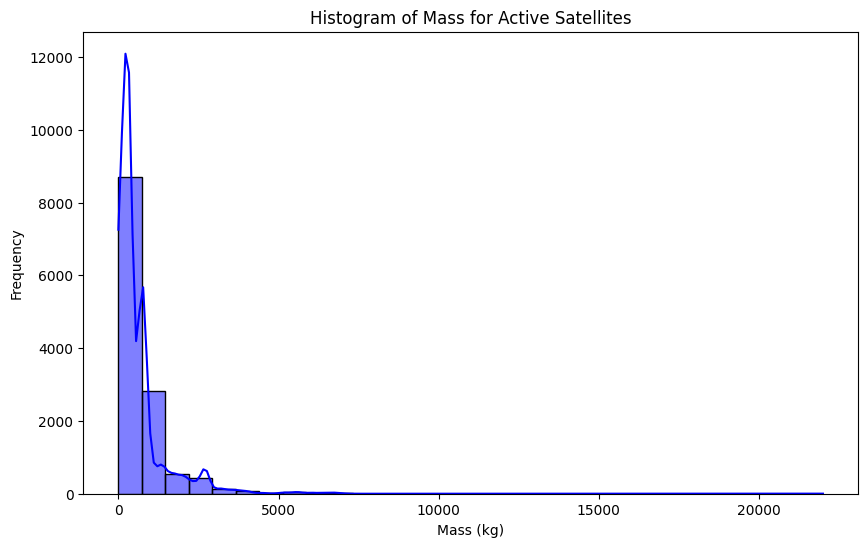

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_43329/3222019206.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pc_thresh', data=active_sats, palette='Oranges')


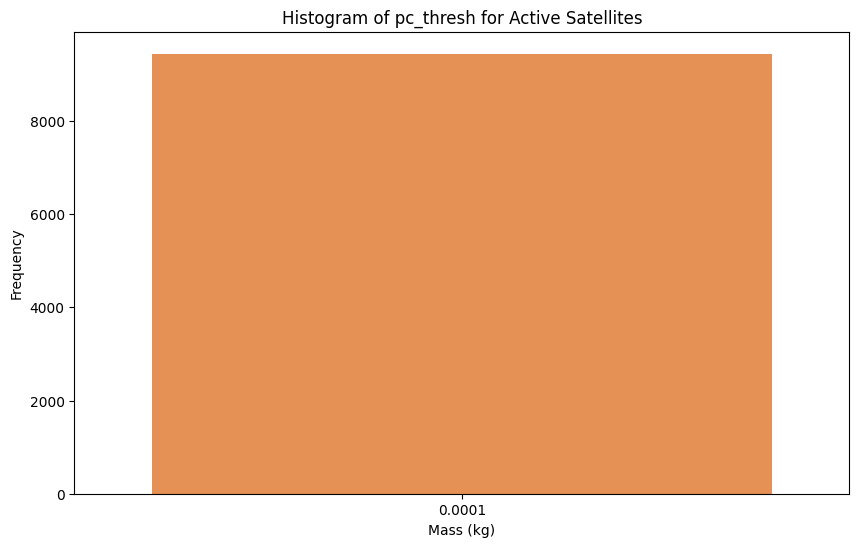

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_43329/3222019206.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='maneuverable', data=active_sats, palette='Greens')


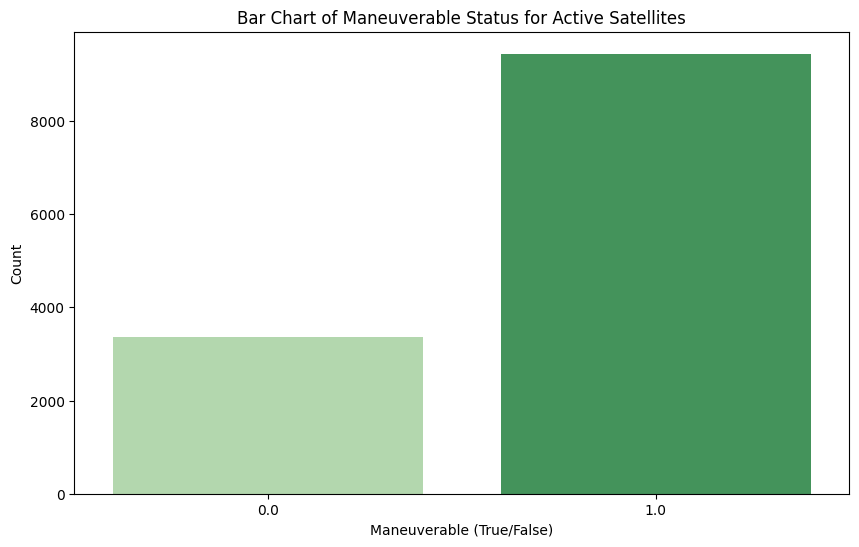

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_43329/3222019206.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stkp_flg', data=active_sats, palette='Oranges')


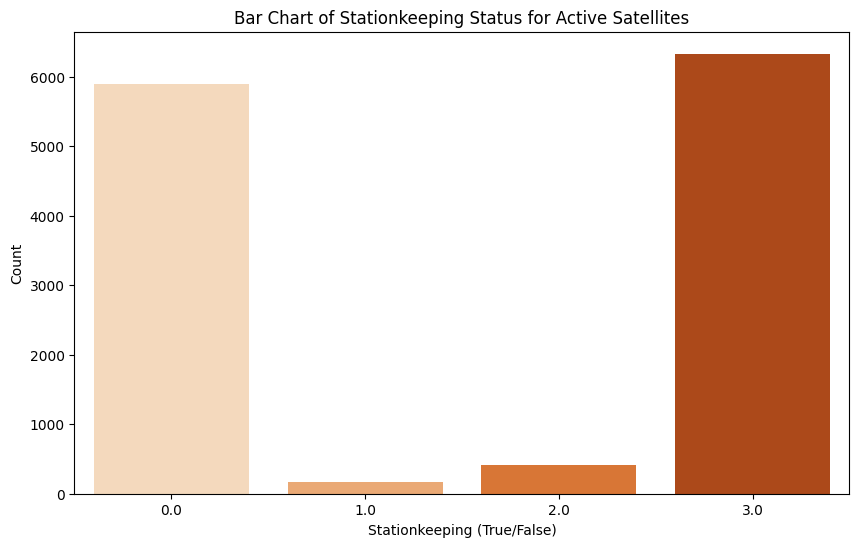

In [94]:
active_sats = T[T['obj_type'] == 2]

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for mass
plt.figure(figsize=(10, 6))
sns.histplot(active_sats['mass'], bins=30, kde=True, color='blue')
plt.title('Histogram of Mass for Active Satellites')
plt.xlabel('Mass (kg)')
plt.ylabel('Frequency')
plt.show()

# Histogram for alpha
plt.figure(figsize=(10, 6))
sns.countplot(x='pc_thresh', data=active_sats, palette='Oranges')
plt.title('Histogram of pc_thresh for Active Satellites')
plt.xlabel('Mass (kg)')
plt.ylabel('Frequency')
plt.show()

# Bar chart for maneuverable
plt.figure(figsize=(10, 6))
sns.countplot(x='maneuverable', data=active_sats, palette='Greens')
plt.title('Bar Chart of Maneuverable Status for Active Satellites')
plt.xlabel('Maneuverable (True/False)')
plt.ylabel('Count')
plt.show()

# Bar chart for stationkeeping
plt.figure(figsize=(10, 6))
sns.countplot(x='stkp_flg', data=active_sats, palette='Oranges')
plt.title('Bar Chart of Stationkeeping Status for Active Satellites')
plt.xlabel('Stationkeeping (True/False)')
plt.ylabel('Count')
plt.show()

In [3]:
# print each column name, the data type and an example
for col in data.columns:
    print(f"Column: {col}")
    print(f"Data Type: {data[col].dtype}")
    print(f"Example: {data[col].iloc[0]}")
    print()

Column: obj_id
Data Type: int64
Example: 1

Column: phase_desc
Data Type: object
Example: debris/derelict

Column: phase
Data Type: int64
Example: 4

Column: par_id
Data Type: float64
Example: nan

Column: mass
Data Type: float64
Example: 1.47

Column: area
Data Type: float64
Example: 0.0214

Column: diam_lcola
Data Type: float64
Example: 0.165068

Column: diam_tumbl
Data Type: float64
Example: 0.131711

Column: diam_char
Data Type: float64
Example: 0.146674

Column: obj_type
Data Type: int64
Example: 2

Column: length
Data Type: float64
Example: nan

Column: width
Data Type: float64
Example: nan

Column: depth
Data Type: float64
Example: nan

Column: active
Data Type: float64
Example: 0.0

Column: maneuverable
Data Type: float64
Example: 0.0

Column: stkp_flg
Data Type: float64
Example: 0.0

Column: stkp_box_r
Data Type: float64
Example: 0.0

Column: stkp_box_i
Data Type: float64
Example: 0.0

Column: stkp_box_c
Data Type: float64
Example: 0.0

Column: disp_type
Data Type: float64
Exa

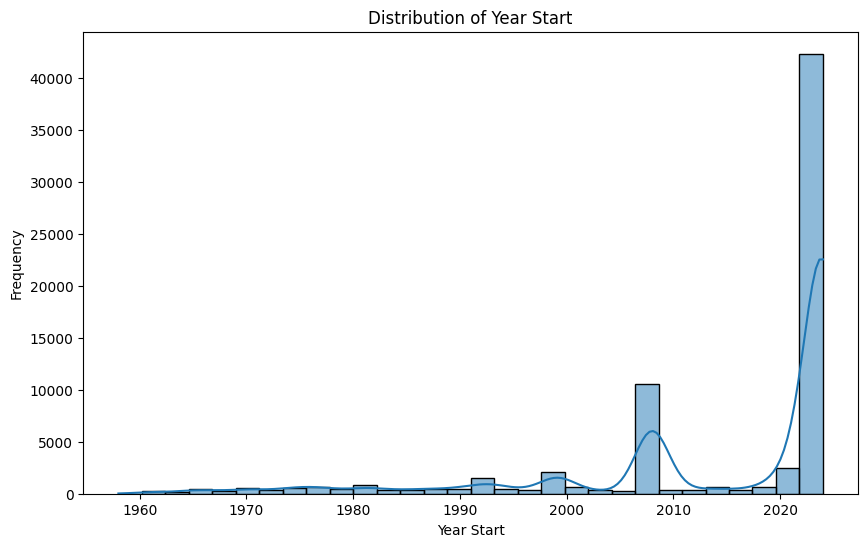

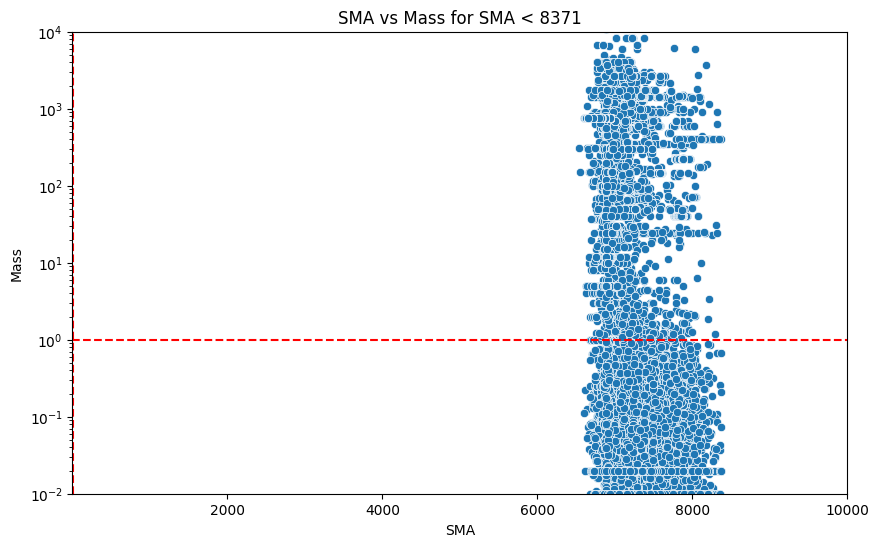

In [14]:
# and plot their sma and mass, if their sma is less than 8371
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data[data['sma'] < 8371], x='sma', y='mass')
plt.title('SMA vs Mass for SMA < 8371')
plt.xlabel('SMA')
plt.ylabel('Mass')
plt.yscale('log')
plt.xlim(1e-2, 1e4)
plt.ylim(1e-2, 1e4)
plt.axhline(1, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')
plt.show()